# Chaines de Markov 
#### Propagation d'une épidémie dans une population

In [55]:
# Importer les librairies nécessaires
import numpy as np
import random as rd 
import matplotlib.pyplot as plt

# Configuration des graphes
import matplotlib as mpl
import seaborn as sns
sns.set(context="notebook", style="whitegrid", palette="hls", font="sans-serif", font_scale=1.4) 
from matplotlib import pyplot, transforms
mpl.rcParams['figure.figsize'] = (15, 10)

Considérons des populations constituées de 3 types d'individus. Chaque individu est dans un des 3 états : sain $S$, infecté $I$ ou guéri $R$. 

Considérons qu'à chaque temps : 
- chaque individu sain peut rester sain ou devenir infecté;
- chaque individu infecté peut rester infecté ou devenir guéri;
- chaque individu guéri reste guéri *(hypothèse pour le premier exo)*

L'information utile pour la prédiction du futur est entièrement contenue dans l'état présent du processus *(propriété de Markov)*.

# 1 - Description du premier modèle

Au temps $t=0$, un individu a une probabilité de $0.9$ d'être sain et $0.1$ d'être infecté.

Un individu dans l'état sain a une probabilité de $0.92$ de rester sain et une probabilité de $0.08$ de devenir infecté. 

Si l'individu est infecté, il peut le rester avec une probabilité de $0.93$ et être guéri avec une probabilité de $0.07$. 

S'il est dans l'état guéri, il reste dans ces état avec une probabilité de $1$. 

![](img/graph.png)

À partir de l'hypothèse supposé au début de l'énoncé, il y a donc trois états, soient sain $S$, infecté $I$ et guéri $R$. Le vecteur de probabilité initiale est de taille $3$ et la matrice de transition est de taille $3\times3$.

On a strictement besoin que : 

$$\pi_0=\{0.9,\, 0.1,\, 0\}$$

$$A = \begin{bmatrix} 0.92 & 0.08 & 0 \\ 0 & 0.93 & 0.07 \\ 0 & 0 & 1 \end{bmatrix}$$

In [30]:
# Fonction pour vérifier qu'une matrice est stochastique et vérifier que A est stochastique
A = [[0.92, 0.08, 0], [0, 0.93, 0.07], [0, 0, 1]]
def is_stochastic(Matrix) : 
  """
  Déterminer si la matrice prise en entrée est stochastique.

  Paramètres
  ---------
    A : matrice à déterminer
  """
  verif = [np.sum(i)==1 for i in Matrix]
  positif = [Matrix[i][j] for i in range(len(Matrix)) for j in range(len(Matrix[i])) if Matrix[i][j]<0]
  return np.sum(verif)==len(Matrix) and len(positif)==0

# Test si A est stochastic
# Le résultat de ce test doit forcément rretourner True
print("A est stochastique" if is_stochastic(A) else "A n'est pas stochastique")

A est stochastique


## 1.1 Distribution théorique
Notons $\pi_t$, le vecteur de probabilité au temps $t$.

On sait que : $\mathbb{P}(C_{0}=S) = 0.9$, $\mathbb{P}(C_{0}=I) = 0.1$, $\mathbb{P}(C_{0}=R) = 0$ et que $\pi

---

Au temps $t=1$, on a : 

$\mathbb{P}(C_{1}=S) = \sum_{i\in\{S,I,R\}} \mathbb{P}(C_{1}=S, C_0=i) = \mathbb{P}(C_{0}=S|C_0=i)\mathbb{P}(C_0=i) = 0.92*0.9 = 0.828$

$\mathbb{P}(C_{1}=I) = \sum_{i\in\{S,I,R\}} \mathbb{P}(C_{1}=I, C_0=i) = \mathbb{P}(C_{0}=I|C_0=i)\mathbb{P}(C_0=i) = 0.08*0.9 + 0.93*0.1 = 0.165$

$\mathbb{P}(C_{1}=R) = \sum_{i\in\{S,I,R\}} \mathbb{P}(C_{1}=R, C_0=i) = \mathbb{P}(C_{0}=R|C_0=i)\mathbb{P}(C_0=i) = 0.07 * 0.1 = 0.007$

On obtient $\pi_1 = \{0.828,\, 0.165,\, 0.007\}$

---

Au temps $t=2$, on a : 

$\mathbb{P}(C_{2}=S) = \sum_{i\in\{S,I,R\}} \mathbb{P}(C_{2}=S, C_1=i) = \mathbb{P}(C_{1}=S|C_1=i)\mathbb{P}(C_1=i) = 0.92*0.828 = 0.76176$

$\mathbb{P}(C_{2}=I) = \sum_{i\in\{S,I,R\}} \mathbb{P}(C_{2}=I, C_1=i) = \mathbb{P}(C_{1}=I|C_1=i)\mathbb{P}(C_1=i) = 0.08*0.828 + 0.93*0.165 = 0.21969$

$\mathbb{P}(C_{2}=R) = \sum_{i\in\{S,I,R\}} \mathbb{P}(C_{2}=R, C_1=i) = \mathbb{P}(C_{1}=R|C_1=i)\mathbb{P}(C_1=i) = 0.07 * 0.165 + 0.007*1 = 0.01855$

On obtient $\pi_1 = \{0.76176,\, 0.21969,\, 0.01855\}$

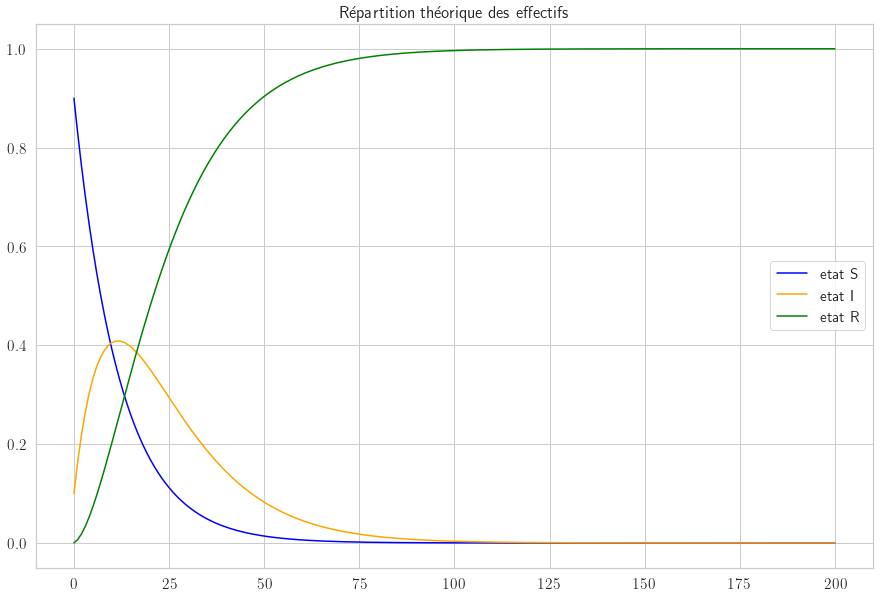

In [58]:
# Calcul de la distrubution théorique, t entre 1 et 200
A = [[0.92, 0.08, 0], [0, 0.93, 0.07], [0, 0, 1]]
pi_0 = [0.9, 0.1, 0]

S, I, R = [pi_0[0]], [pi_0[1]], [pi_0[2]]

for i in range(1,201) :
  pi_0 = np.dot(pi_0, A)
  S.append(pi_0[0]); I.append(pi_0[1]); R.append(pi_0[2])

# Plot
plt.plot(S, c="blue", label="etat S")
plt.plot(I, c="orange", label="etat I")
plt.plot(R, c="green", label="etat R")

plt.title(r"Répartition théorique des effectifs")
plt.legend(loc="center right")

## 1.2 Distribution observée
### 1.2.1 Tirage aléatoire des états


In [3]:
# Pour générer une séquence aléatoire de taille T avec la chaine de Markov donnée ci-dessus
def generate_markov_sequence(T, pi_0, A):
  """
  Générer une séquence aléatoire de taille T avec la chaine de Markov fournie. 
    
  Paramètres
  ---------
    T : le temps passé par l'individu 
    pi_0 : état pi_0 de début
    A : matrice de transition
  """
  current_state = np.random.choice([0, 1, 2], p=pi_0)
  sequence = []   # États par lesquels un individu durant T jours

  for _ in range(T) : 
    sequence.append(current_state)
    current_state = np.random.choice([0, 1, 2], p=A[current_state])

  return np.array(sequence)


# Définition des paramètres
T = 150
A = [[0.92, 0.08, 0], [0, 0.93, 0.07], [0, 0, 1]]
pi_0 = [0.9, 0.1, 0]

# Générer la séquence aléatoire
sequence = generate_markov_sequence(T, pi_0, A)
print("Séquence générée avec T =", T, ":\n", sequence)

Séquence générée avec T = 150 :
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


### 1.2.2 Modélisation d'une population

In [4]:
def GeneratePopulation(T, Effectif, pi_0, A) : 
  """
  Générer un nombre `Effectif` d'informations concernant les individus en étude.
    
  Paramètres
  ---------
    T : le temps passé par l'individu 
    Effectif : nombre total d'individus en étude
    pi_0 : état pi_0 de début
    A : matrice de transition
  """
  return np.array([generate_markov_sequence(T, pi_0, A) for _ in range(Effectif)])

#### a. Évolution d'une population de 200 individus

In [7]:
T = 150
Effectif = 200
A = [[0.92, 0.08, 0], [0, 0.93, 0.07], [0, 0, 1]]
pi_0 = [0.9, 0.1, 0]

Population = GeneratePopulation(T, Effectif, pi_0, A)
print("Len Population :", len(Population), "\nTemps T :", len(Population[0]))
Population

Len Population : 200 
Temps T : 150


array([[0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       ...,
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2]])

In [61]:
def affiche_repartition_sir(T, Effectif, pi_0, A) : 
  """
  Procéder consécutivement les étapes suivants : 
  1. À chaque temps t, comptez le nombre d'individus sains, infectés et guéris dans la population et affichez l'évolution du nombre d'individus dans les trois états en fonction du temps.
  2. Affichez le pourcentage d'individus sains, infectés et guéris en fonction du temps.
    
  Paramètres
  ---------
    T : le temps passé par l'individu 
    Effectif : nombre total d'individus en étude
    pi_0 : état pi_0 de début
    A : matrice de transition
  """
  population = GeneratePopulation(T, Effectif, pi_0, A)
  S, I, R = np.zeros(T), np.zeros(T), np.zeros(T)

  # 1. 
  # comptez le nombre d'individus sains, infectés et guéris dans la population
  for t in range(T) : 
    S[t] += np.sum([population[p][t]==0 for p in range(Effectif)])
    I[t] += np.sum([population[p][t]==1 for p in range(Effectif)])
    R[t] += np.sum([population[p][t]==2 for p in range(Effectif)])
  
  # affichez l'évolution du nombre d'individus dans les trois états en fonction du temps
  ax1 = plt.subplot(221)

  ax1.plot(S, c="blue", label="etat S")
  ax1.plot(I, c="orange", label="etat I")
  ax1.plot(R, c="green", label="etat R")

  ax1.set_title(r"Effectif observé sur une population de {} individus".format(Effectif))
  ax1.legend(loc="center right")



  # 2. Affichez le pourcentage d'individus sains, infectés et guéris en fonction du temps
  ax2 = plt.subplot(222)
  S = S/Effectif; I = I/Effectif; R = R/Effectif

  ax2.plot(S, c="blue", label="pourcentage d'individu sain")
  ax2.plot(I, c="orange", label="pourcentage d'individu infecté")
  ax2.plot(R, c="green", label="pourcentage d'individu guéri")

  ax2.set_title(r"Distribution observé sur une population de {} individus".format(Effectif))
  ax2.legend(loc="center right")

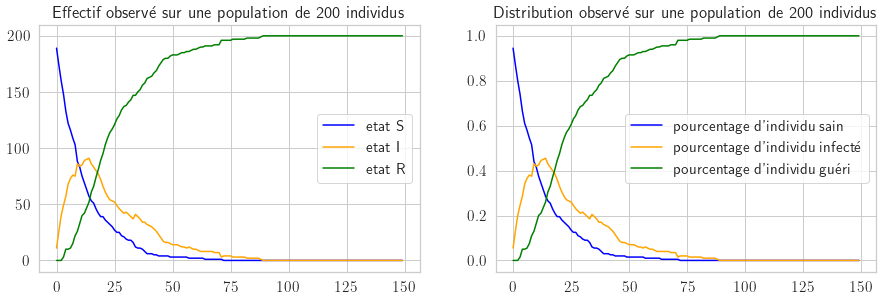

In [62]:
T = 150
Effectif = 200
A = [[0.92, 0.08, 0], [0, 0.93, 0.07], [0, 0, 1]]
pi_0 = [0.9, 0.1, 0]

affiche_repartition_sir(T, Effectif, pi_0, A)

>##### Remarque
>À partir des graphes simulés ci-dessous, on peut observer que plus $t$ est grand, plus la proportion d'individus sains et infectés s'approchent de $0$, et en revanche, plus la proportion d'individus guéris se converge vers $1$.

#### b. Évolution d'une population de 5 individus

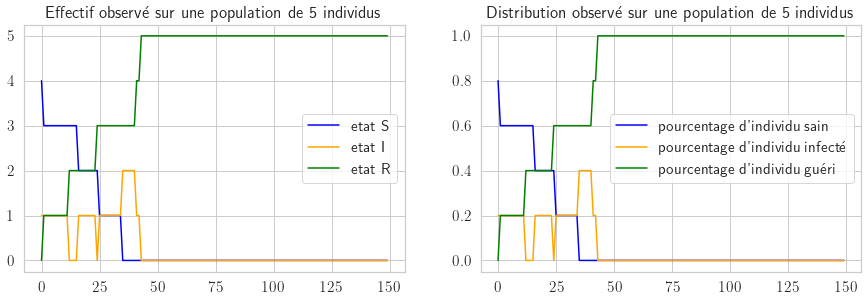

In [63]:
T = 150
Effectif = 5
A = [[0.92, 0.08, 0], [0, 0.93, 0.07], [0, 0, 1]]
pi_0 = [0.9, 0.1, 0]

affiche_repartition_sir(T, Effectif, pi_0, A)

#### c. Évolution d'une population de 5000 individus

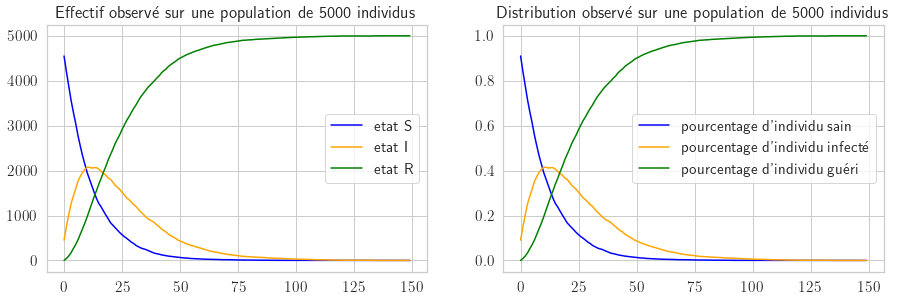

In [64]:
T = 150
Effectif = 5000
A = [[0.92, 0.08, 0], [0, 0.93, 0.07], [0, 0, 1]]
pi_0 = [0.9, 0.1, 0]

affiche_repartition_sir(T, Effectif, pi_0, A)

#### d. Évolution d'une population de 50000 individus

In [65]:
T = 150
Effectif = 50000
A = [[0.92, 0.08, 0], [0, 0.93, 0.07], [0, 0, 1]]
pi_0 = [0.9, 0.1, 0]

affiche_repartition_sir(T, Effectif, pi_0, A)

## 1.3 Longueur d'infection

In [6]:
def infection_length(T, Effectif, pi_0, A) : 
  """
  Retourne la séquence I contenant l'information sur les individus infectés.
    
  Paramètres
  ---------
    T : le temps passé par l'individu 
    Effectif : nombre total d'individus en étude
    pi_0 : état pi_0 de début
    A : matrice de transition
  """
  population = GeneratePopulation(T, Effectif, pi_0, A)
  length = []

  for e in range(Effectif) : 
    length.append(len([population[e][t] for t in range(T) if population[e][t]==1]))
  
  return length

In [161]:
T = 200
Effectif = 1000
A = [[0.92, 0.08, 0], [0, 0.93, 0.07], [0, 0, 1]]
pi_0 = [0.9, 0.1, 0]

# 1. Estimez la longueur moyenne d'une séquence de I
I = infection_length(T, Effectif, pi_0, A)
print("I =", I)
moyenne_observee = np.mean(I)
print("Moyenne observée =", moyenne_observee)

# 2. Calculez la longueur théorique d'une séquence de I
# Simulation de la chaîne de Markov pour T étapes
pi_t = pi_0
for t in range(T) : 
  pi_t = np.dot(pi_t, A)

# Calcul de la moyenne du nombre d'étapes passées dans l'état infecté
p = sum((t + 1) * pi_t[1] for t in range(T))
moyenne_theorique = 1/p     # Espérance de la loi géométrique
print("Moyenne théorique =", moyenne_theorique)

I = [8, 2, 44, 11, 8, 1, 7, 8, 40, 2, 4, 3, 19, 98, 13, 5, 14, 5, 3, 27, 1, 17, 11, 39, 7, 43, 16, 14, 29, 2, 27, 5, 1, 25, 22, 30, 12, 6, 1, 4, 3, 1, 2, 65, 12, 1, 5, 17, 40, 37, 13, 49, 2, 3, 1, 13, 38, 1, 5, 3, 3, 2, 8, 13, 46, 5, 15, 14, 44, 12, 35, 3, 16, 8, 9, 1, 5, 15, 3, 2, 3, 7, 1, 15, 21, 29, 10, 18, 22, 5, 25, 4, 18, 11, 6, 12, 29, 24, 12, 19, 3, 13, 4, 18, 30, 4, 4, 5, 18, 11, 9, 25, 2, 3, 19, 20, 33, 19, 12, 1, 23, 13, 20, 2, 24, 10, 6, 2, 2, 41, 8, 19, 32, 7, 10, 4, 7, 1, 31, 30, 1, 18, 20, 8, 33, 8, 2, 3, 26, 29, 6, 3, 5, 18, 4, 12, 7, 13, 5, 1, 9, 4, 6, 2, 4, 6, 1, 15, 2, 1, 91, 35, 13, 3, 9, 20, 5, 23, 16, 27, 10, 17, 2, 30, 20, 2, 7, 4, 12, 17, 45, 7, 8, 3, 12, 41, 17, 16, 9, 1, 9, 27, 13, 2, 9, 4, 2, 34, 110, 19, 20, 18, 10, 25, 3, 14, 3, 7, 5, 27, 39, 13, 22, 36, 22, 2, 12, 10, 5, 13, 33, 1, 6, 59, 2, 1, 34, 9, 25, 12, 1, 5, 5, 8, 19, 11, 33, 5, 33, 10, 26, 25, 12, 12, 14, 19, 25, 12, 23, 9, 31, 29, 19, 21, 46, 22, 18, 3, 10, 36, 15, 1, 5, 16, 4, 15, 8, 2, 18, 33, 5

> ##### Remarque
>À partir des estimations ci-dessus, on obtient $14.829$ pour la moyenne observée et environ $15.46$ pour la moyenne théorique.  
>
>De plus, après plusieurs simulations, on remarque que la moyenne observée est inférieure à la moyenne théorique. 

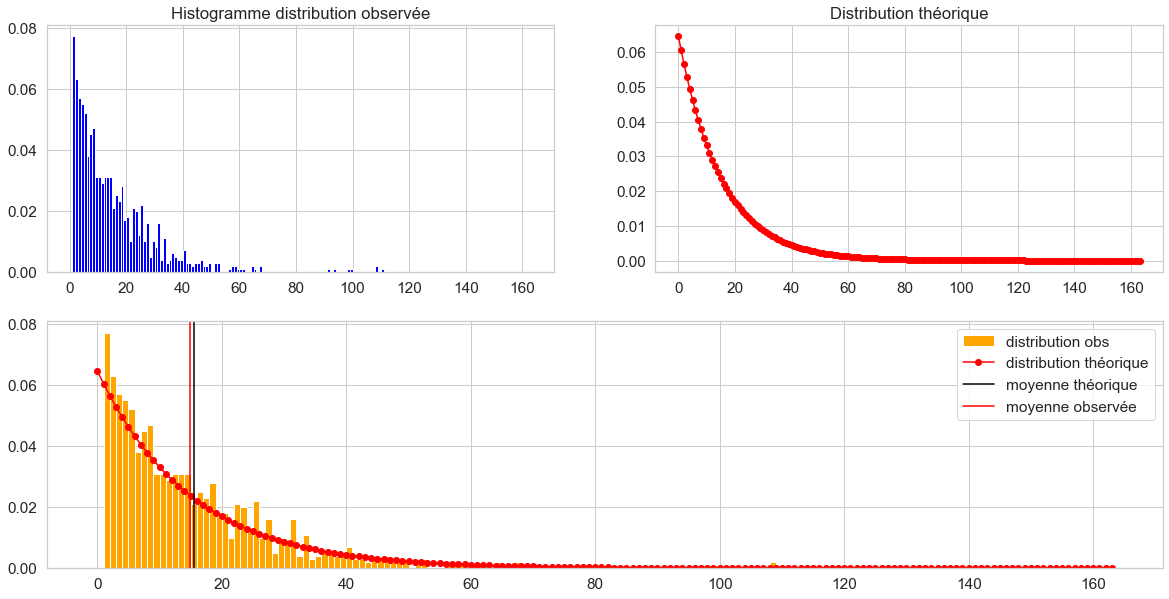

In [163]:
# 4. Afficher la distribution observée de la longueur d'infection (un histogramme)
plt.figure(figsize=(20,10))
ax1 = plt.subplot(221)
ax1.hist(I, bins=range(0, np.max(I), 1), density=True, color="blue")
ax1.set_title("Histogramme distribution observée")

# 5. Affichez et superposer la distribution théorique de la longueur d’infection et la distribution observée.
ax2 = plt.subplot(222)
sequence = []
for k in range(max(I)) : 
  sequence.append((1-p)**k * p)

ax2.plot(range(max(I)), sequence,'ro-')
ax2.set_title("Distribution théorique")


ax3 = plt.subplot(212)
ax3.hist(I, bins=range(0, np.max(I), 1), density=True, color="orange", label="distribution obs")
ax3.plot(range(max(I)), sequence,'ro-', label="distribution théorique")
ax3.axvline(x=moyenne_theorique, color='black', label='moyenne théorique')
ax3.axvline(x=moyenne_observee, color='red', label='moyenne observée')
ax3.legend(loc="upper right")
 

## 1.4 Apprentissage des paramètres du modèle à partir des données

In [8]:
def determine_matrice_transition(population) : 
  """
  À partir d'une séquence d'observation (un indiv), estimez la matrice de probabilité de transitions.
  À noter que le nombre d'individus dans la chaine `population` peut varier.
    
  Paramètres
  ---------
    population : la chaine d'individus étudiés basé sur laquelle on estime la matrice de transition.
  """
  nb_indiv = len(population)
  A = [[0] * 3 for _ in range(3)]
  if nb_indiv>1 : 
    for i in range(nb_indiv) : 
      for j in range(len(population[i])-1) : 
        current_state = population[i][j]
        next_state = population[i][j+1]
        A[current_state][next_state] += 1
  else : 
    for j in range(len(population[0])-1) : 
      current_state = population[0][j]
      next_state = population[0][j+1]
      A[current_state][next_state] += 1

  for row in A :
    total_transitions = sum(row)
    if total_transitions > 0:
        row[:] = [count / total_transitions for count in row]
  return A

In [27]:
T = 200
A = [[0.92, 0.08, 0], [0, 0.93, 0.07], [0, 0, 1]]
pi_0 = [0.9, 0.1, 0]

# nb_indiv = 1
pop = GeneratePopulation(T, 1, pi_0, A)
Matrix = determine_matrice_transition(pop)
print("La matrice de transition A quand le nombre d'individu = 1 :", Matrix)

# nb_indiv = 10
pop = GeneratePopulation(T, 10, pi_0, A)
Matrix = determine_matrice_transition(pop)
print("La matrice de transition A quand le nombre d'individu = 10 :", Matrix)

# nb_indiv = 30
pop = GeneratePopulation(T, 30, pi_0, A)
Matrix = determine_matrice_transition(pop)
print("La matrice de transition A quand le nombre d'individu = 30 :", Matrix)

# nb_indiv = 100
pop = GeneratePopulation(T, 100, pi_0, A)
Matrix = determine_matrice_transition(pop)
print("La matrice de transition A quand le nombre d'individu = 100 :", Matrix)

# nb_indiv = 1000
pop = GeneratePopulation(T, 1000, pi_0, A)
Matrix = determine_matrice_transition(pop)
print("La matrice de transition A quand le nombre d'individu = 1000 :", Matrix)

La matrice de transition A quand le nombre d'individu = 1 : [[0.8888888888888888, 0.1111111111111111, 0.0], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0]]
La matrice de transition A quand le nombre d'individu = 10 : [[0.8933333333333333, 0.10666666666666667, 0.0], [0.0, 0.8888888888888888, 0.1111111111111111], [0.0, 0.0, 1.0]]
La matrice de transition A quand le nombre d'individu = 30 : [[0.9265822784810127, 0.07341772151898734, 0.0], [0.0, 0.9264705882352942, 0.07352941176470588], [0.0, 0.0, 1.0]]
La matrice de transition A quand le nombre d'individu = 100 : [[0.9117361784675073, 0.08826382153249272, 0.0], [0.0, 0.9401555954518253, 0.059844404548174746], [0.0, 0.0, 1.0]]
La matrice de transition A quand le nombre d'individu = 1000 : [[0.9217323245499609, 0.07826767545003914, 0.0], [0.0, 0.9249643580700833, 0.07503564192991671], [0.0, 0.0, 1.0]]


>##### Remarque
>À partir des matrices de probabilité de transitions estimées ci-dessus, on trouve que pour approximer correctement le modèle, on a besoin d'au moins $30$ individus. 

# 2 Description du second modèle
**Hypothèse** : Considérons un second modèle, les individus guéris peuvent redevenir sains avec une probabilité de $0.02$. Ils peuvent perdre leur immunité face à la maladie. 

![](img/2.png)

## Analyse du modèle
Vu le diagramme représentant les 3 états du modèles et les probilités de transition ci-dessus, ce processus satisfait aux critères pour être modélisé par une chaîne de Markov.

Dans ce cas :

- État $S$ a $92\%$ de rester dans l'état $S$, $8\%$ de passer à l'état $I$ et $0\%$ d'aller à l'état $R$.
- État $I$ a $0\%$ de passer à l'état $S$, $93\%$ de rester dans l'état $I$ et $7\%$ d'aller à l'état $R$.
- État $R$ a $2\%$ de transitions vers l'état $S$, $0\%$ vers l'état $I$ et reste à $98\%$ dans l'état $SR$.

Ces probabilités de transition respectent la condition clé d'une chaîne de Markov où la somme des probabilités de passer à tous les autres états à partir d'un état donné est égale à $1$.

À partir du diagramme, la nouvelle matrice de transition est définie comme suit : 
$$A = \begin{bmatrix} 0.92 & 0.08 & 0 \\ 0 & 0.93 & 0.07 \\ 0.02 & 0 & 0.98 \end{bmatrix}$$

### Nature des états du modèle

Dans la matrice de transition $A$, on peut déterminer la nature des états en se basant sur les probabilités de transition.

- État $S$ : Il a une probabilité de $92\%$ de rester dans l'état $S$ *(auto-transition)*, $8\%$ de passer à l'état $I$ et $0\%$ d'aller à l'état $R$. Cela indique que l'état $S$ est un **état transitoire** avec des probabilités de transitions vers d'autres états.

- État $I$ : Il a $0\%$ de probabilité de revenir à l'état $S$, $93\%$ de rester dans l'état $I$ *(auto-transition)*, et $7\%$ d'aller à l'état $R$. Comme pour l'état $S$, l'état $I$ est un **état transitoire** avec des probabilités de transitions vers d'autres états.

- État $R$ : Il a $2\%$ de probabilité de revenir à l'état $S$, $0\%$ de passer à l'état $I$ et $98\%$ de rester dans l'état $R$ *(auto-transition)*. Cela signifie que l'état $R$ est un **état absorbant**, car une fois dans cet état, la chaîne reste dans cet état indéfiniment.

En conclusion, dans cette chaîne de Markov définie par la matrice de transition $A$, les états $S$ et $I$ sont des **états transitoires** avec des probabilités de transition vers d'autres états, tandis que l'état $R$ est un **état absorbant**, car la probabilité de rester dans cet état est de $98\%$ et il n'y a pas de transitions sortantes depuis cet état.

### Péiodicité - Irréductivité

1. **Périodicité** : La chaîne de Markov définie par cette matrice est apériodique. Il n'y a pas de cycles ou de boucles où la chaîne reviendrait à un état précédent après un nombre fixe d'étapes. Il n'y a pas de motif régulier de retour à un état spécifique, donc la chaîne est apériodique.

2. **Irréductibilité** : Pour déterminer l'irréductibilité, il faut vérifier si chaque état peut être atteint depuis n'importe quel autre état, directement ou indirectement, avec une probabilité positive. Dans cette matrice, chaque état peut être atteint depuis les autres états avec une probabilité positive, ce qui signifie que la chaîne est irréductible.

En court terme, la chaîne de Markov définie par la matrice de transition $A$ est apériodique et irréductible.

In [53]:
print("Test de stochasticité")
print("=====================")
A = [[0.92, 0.08, 0], [0, 0.93, 0.07], [0.02, 0, 0.98]]
print("A est stochastique" if is_stochastic(A) else "A n'est pas stochastique")

# Calculez A^2 = AxA
A2 = np.dot(A, A)
print("A^2 est stochastique" if is_stochastic(A2) else "A^2 n'est pas stochastique")

# Calculez A^3 = A^2xA
A3 = np.dot(A2, A)
print("A^3 est stochastique" if is_stochastic(A3) else "A^3 n'est pas stochastique")

# Calculez A^4 = A^3xA
A4 = np.dot(A3, A)
print("A^4 est stochastique" if is_stochastic(A4) else "A^4 n'est pas stochastique")

Test de stochasticité
A est stochastique
A^2 n'est pas stochastique
A^3 n'est pas stochastique
A^4 n'est pas stochastique


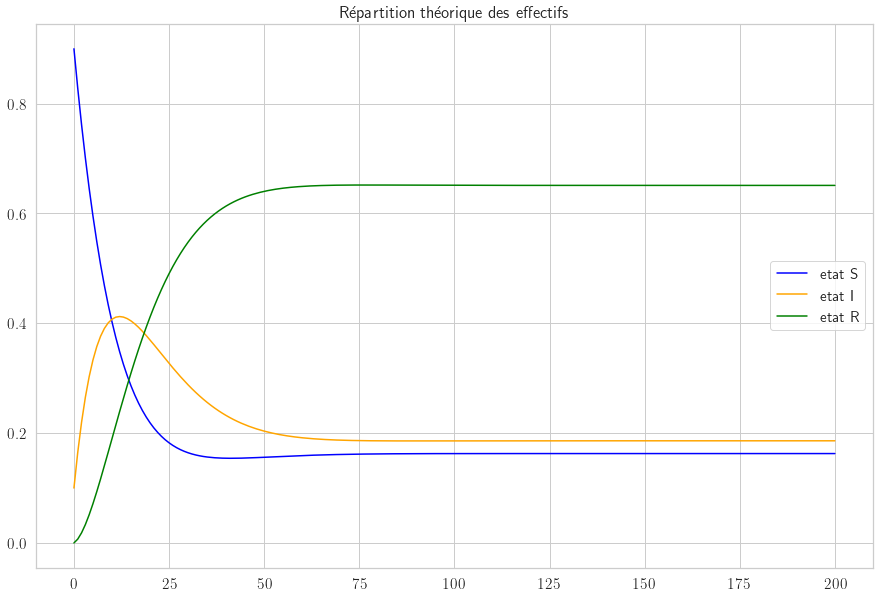

In [59]:
# Calcul de la distrubution théorique, t entre 1 et 200
A = [[0.92, 0.08, 0], [0, 0.93, 0.07], [0.02, 0, 0.98]]
pi_0 = [0.9, 0.1, 0]

S, I, R = [pi_0[0]], [pi_0[1]], [pi_0[2]]

for i in range(1,201) :
  pi_0 = np.dot(pi_0, A)
  S.append(pi_0[0]); I.append(pi_0[1]); R.append(pi_0[2])

# Plot
plt.plot(S, c="blue", label="etat S")
plt.plot(I, c="orange", label="etat I")
plt.plot(R, c="green", label="etat R")

plt.title(r"Répartition théorique des effectifs")
plt.legend(loc="center right")

>##### Remarque
>
>
>

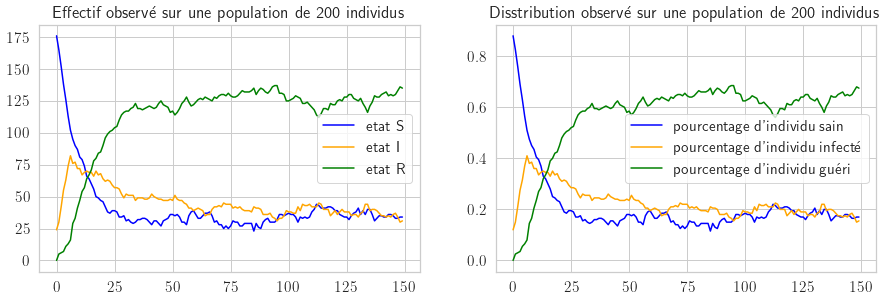

In [60]:
T = 150
Effectif = 200
A = [[0.92, 0.08, 0], [0, 0.93, 0.07], [0.02, 0, 0.98]]
pi_0 = [0.9, 0.1, 0]

affiche_repartition_sir(T, Effectif, pi_0, A)